# RAMP on predicting cyclist traffic in Paris


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Loading the data with pandas

First, download the data files from Kaggle, and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [2]:
data = pd.read_parquet("data/train.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


We can check general information about different columns:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[us]
 6   counter_installation_date  455163 non-null  datetime64[us]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[us](2), float64(4), int64(

and in particular the number of unique entries in each column,

In [8]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    977
date                         8230
counter_installation_date      22
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                977
dtype: int64

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations:

In [9]:
(
    data.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

/var/folders/k7/yjlj1gk15bj1gjrxppqlsy9r0000gn/T/ipykernel_69433/1192055722.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name", "counter_name"])["bike_count"].sum()


,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1809231.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1406900.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1357868.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1036575.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,914089.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,888717.0
Quai d'Orsay,Quai d'Orsay E-O,849724.0
Totem Cours la Reine,Totem Cours la Reine O-E,806149.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,806071.0


# Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [10]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

/Users/augustin2staff/Documents/GitHub/bike_counters/bike-counts-3.11.4/lib/python3.11/site-packages/folium/utilities.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = (location[0], location[1])


Note that in this challenge, we consider only the 30 most frequented counting sites, to limit data size.

Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points:

<Axes: xlabel='date'>

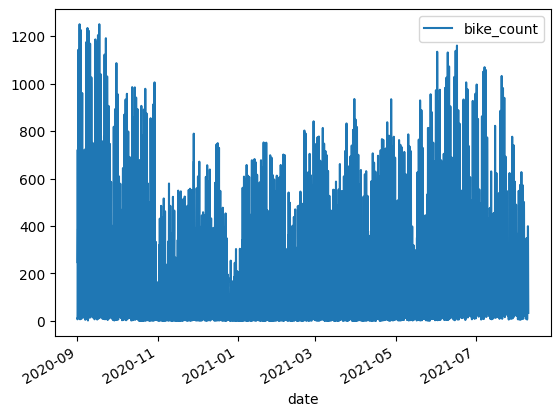

In [11]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot(x="date", y="bike_count")

Instead we aggregate the data, for instance, by week to have a clearer overall picture:

<Axes: xlabel='date'>

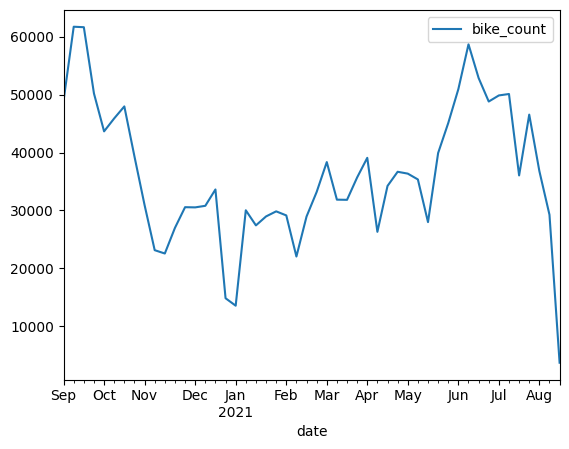

In [12]:
mask = (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")

data[mask].groupby(
    pd.Grouper(freq="1w", key="date")
)[["bike_count"]].sum().plot()

While at the same time, we can zoom on a week in particular for a more short-term visualization,

<Axes: xlabel='date'>

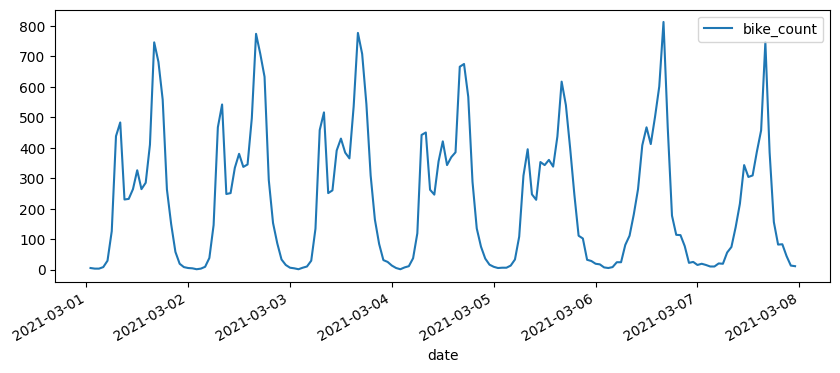

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021/03/01"))
    & (data["date"] < pd.to_datetime("2021/03/08"))
)

data[mask].plot(x="date", y="bike_count", ax=ax)

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

/Users/augustin2staff/Documents/GitHub/bike_counters/bike-counts-3.11.4/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/augustin2staff/Documents/GitHub/bike_counters/bike-counts-3.11.4/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


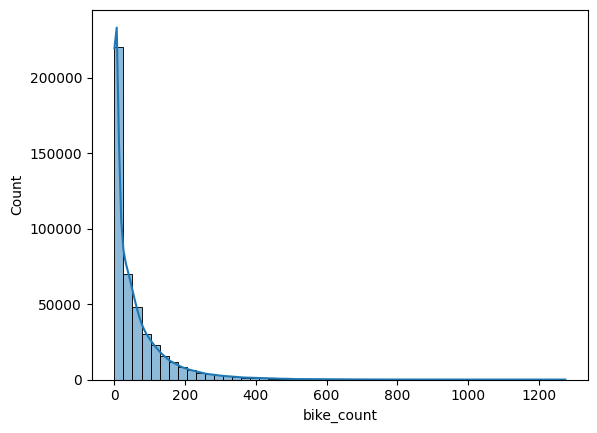

In [14]:
import seaborn as sns


ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

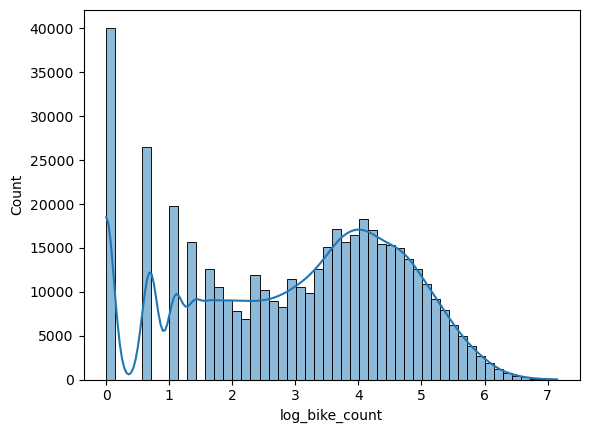

In [14]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

# Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field:

In [15]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [16]:
data["date"].head()

48321   2020-09-01 02:00:00
48324   2020-09-01 03:00:00
48327   2020-09-01 04:00:00
48330   2020-09-01 15:00:00
48333   2020-09-01 18:00:00
Name: date, dtype: datetime64[us]

In [17]:
_encode_dates(data[["date"]].head())

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html):

In [18]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
sample_encoded = date_encoder.fit_transform(data[["date"]]).head()
sample_encoded

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [19]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

enc.fit_transform(sample_encoded[["hour"]])

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

# Linear model (Vincent)

Let's now construct our first linear model with [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). We use a few helper functions defined in `utils.py` of the starting kit to load the train set.

In [29]:
import utils

X, y = utils.get_train_data()
X.head(2)

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233


and

In [30]:
y

array([1.60943791, 1.38629436, 0.        , ..., 2.48490665, 1.60943791,
       1.38629436])

Where `y` contains the `log_bike_count` variable. 

To test our baseline estimator, we create a validations set from the training set. Note that, during modeling and exploring the data, we always recommend using cross validation rather than a single train / validation split to evaluate your first results, because this will bring more stability and generalization.

We create the validation set by simply slicing the last 30 days of the training set:

In [31]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [32]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=414843,  2020-09-01 01:00:00 to 2021-07-10 23:00:00
Valid: n_samples=40320,  2021-07-11 00:00:00 to 2021-08-09 23:00:00


In [33]:
_encode_dates(X_train[["date"]]).columns.tolist()

['year', 'month', 'day', 'weekday', 'hour']

In [34]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x12f634ae0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

We then evaluate this model with the RMSE metric,

In [35]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

Train set, RMSE=0.80
Valid set, RMSE=0.85


The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [36]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.70
Test set, RMSE=1.42


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations (we transform the logarithmic bike counts back to their original unit):

In [38]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/08/01"))
    & (X_valid["date"] < pd.to_datetime("2021/08/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

Text(0, 0.5, 'bike_count')

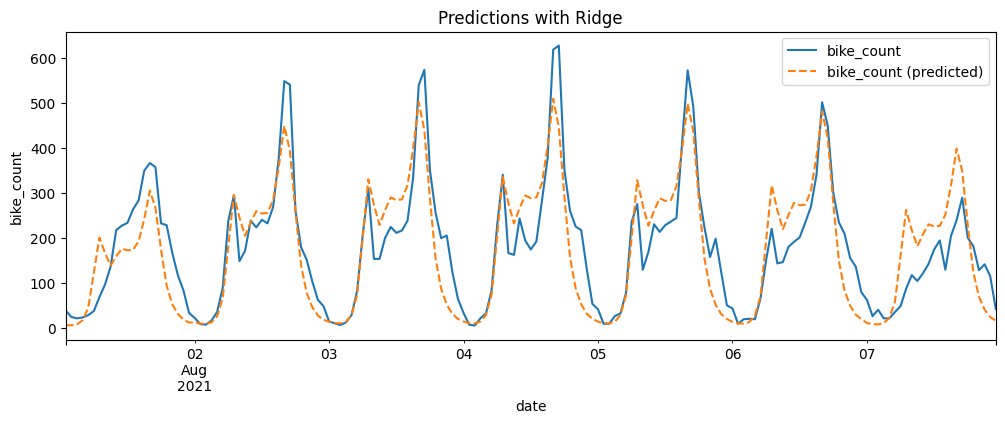

In [39]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

<Axes: xlabel='y_true', ylabel='y_pred'>

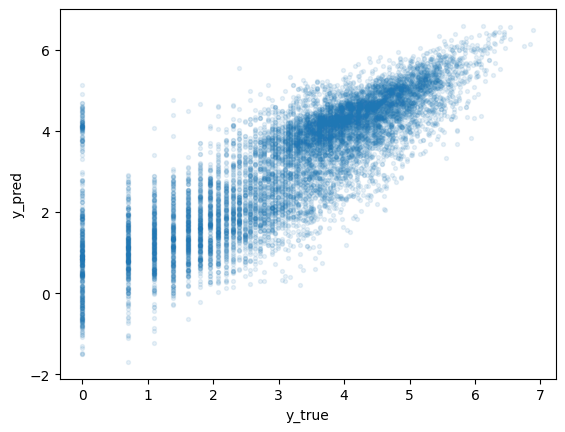

In [40]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_valid, "y_pred": pipe.predict(X_valid)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores:

In [41]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.99836302 -0.8478686  -0.91118938 -0.77449446 -0.97062445 -1.13838298]
RMSE (all folds): 0.94 ± 0.116


# SERVIR PART

## Merging all training data available

In [46]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [6]:
# Merge all the availbale data

data_train = pd.read_parquet("data/train.parquet")
data_test = pd.read_parquet("data/test.parquet")

data_train = pd.concat((data_train, data_test)).sort_values(["date", "counter_name"])
external_data = pd.read_csv("external_data/external_data.csv")

## Additional EDA

/var/folders/k7/yjlj1gk15bj1gjrxppqlsy9r0000gn/T/ipykernel_90584/2817824185.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['hour'] = filtered_data['date'].dt.hour


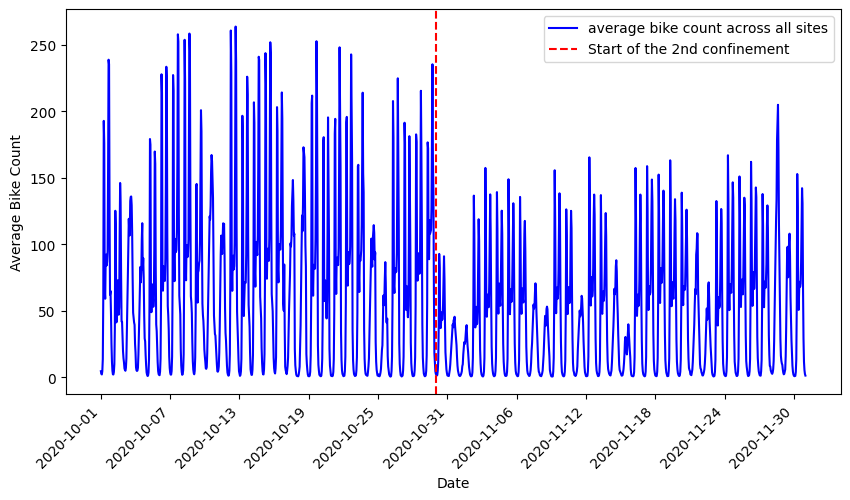

In [7]:
plt.figure(figsize=(10,5))
start_date = '2020-10-01'
end_date = '2020-12-01'
filtered_data = data_train[(data_train['date'] >= start_date) & (data_train['date'] <= end_date)]
filtered_data['hour'] = filtered_data['date'].dt.hour
hourly_site_bike_count = filtered_data.groupby(['date'])['bike_count'].mean().reset_index()
plt.plot(hourly_site_bike_count.iloc[:,0],hourly_site_bike_count.iloc[:,1],color="blue",label="average bike count across all sites")
plt.xlabel('Date')
plt.ylabel('Average Bike Count')
plt.xticks(pd.date_range(start=start_date, end=end_date, freq='6D'), rotation=45, ha='right')
plt.axvline(x=pd.to_datetime('2020-10-30 00:00:00'), color='r', linestyle='--', label='Start of the 2nd confinement')
plt.legend()

/var/folders/k7/yjlj1gk15bj1gjrxppqlsy9r0000gn/T/ipykernel_90584/2754899748.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['hour'] = filtered_data['date'].dt.hour


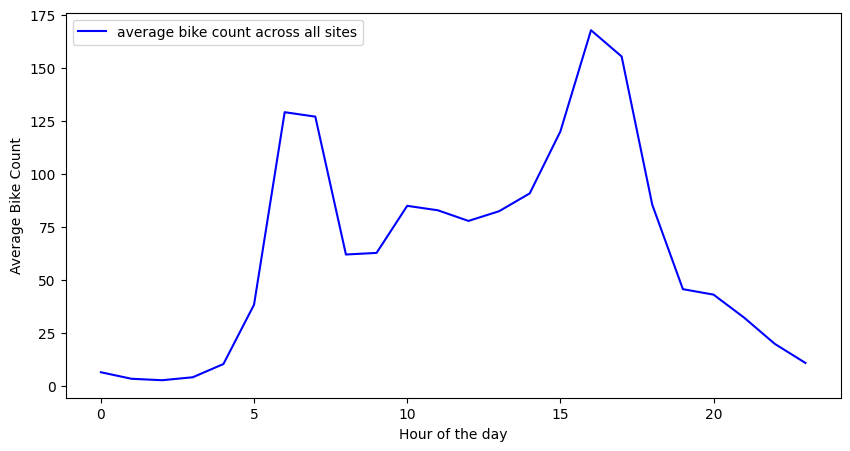

In [8]:
plt.figure(figsize=(10,5))
start_date = '2020-10-01'
end_date = '2020-10-07'
filtered_data = data_train[(data_train['date'] >= start_date) & (data_train['date'] <= end_date)]
filtered_data['hour'] = filtered_data['date'].dt.hour
hourly_site_bike_count = filtered_data.groupby(['hour'])['bike_count'].mean().reset_index()
plt.plot(hourly_site_bike_count.iloc[:,0],hourly_site_bike_count.iloc[:,1],color="blue",label="average bike count across all sites")
plt.xlabel('Hour of the day')
plt.ylabel('Average Bike Count')
plt.legend()

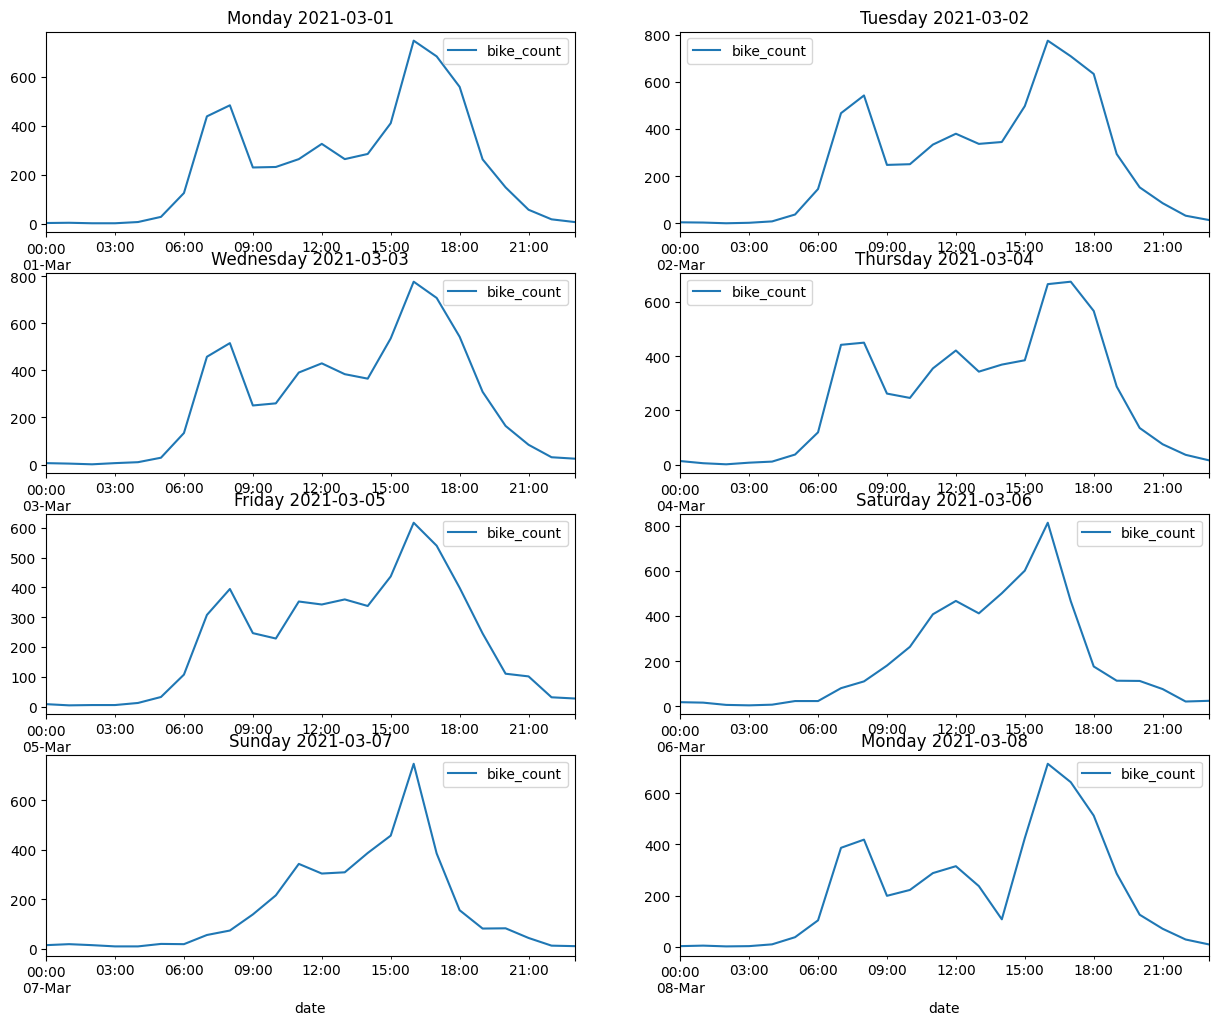

In [9]:
# Set up subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))
axes = axes.flatten()

# Loop over date ranges and create plots
for i, ax in enumerate(axes):
    start_date = pd.to_datetime("2021/03/0" + str(i + 1))
    end_date = pd.to_datetime("2021/03/0" + str(i + 2))

    day_of_week = start_date.strftime('%A')
    title_date = start_date.strftime('%Y-%m-%d')
    
    mask = (
        (data_train["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
        & (data_train["date"] >= start_date)
        & (data_train["date"] < end_date)
    )

    x_values = np.linspace(start_date.timestamp(), end_date.timestamp(), 1000)  # Adjust the number of points as needed
    frequency_scale = 0.1
    cosine_values = np.cos(x_values * frequency_scale) * np.mean(data_train[mask]['bike_count'])

    data_train[mask].plot(x="date", y="bike_count", ax=ax)
    ax.set_title(f"{day_of_week} {title_date}")

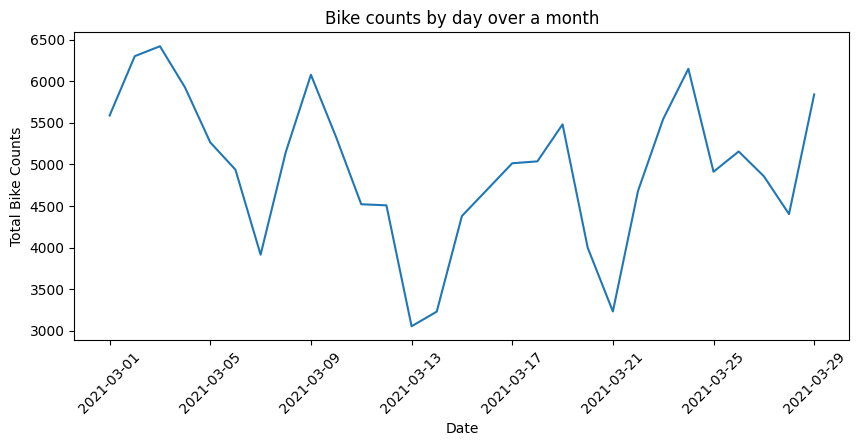

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data_train["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data_train["date"] > pd.to_datetime("2021/03/01"))
    & (data_train["date"] < pd.to_datetime("2021/03/30"))
)

# Sum the bike counts by day
daily_counts = data_train[mask].groupby(data_train[mask]["date"].dt.date)["bike_count"].sum()

# Plot the result
daily_counts.plot(kind='line', ax=ax, rot=45)
ax.set_xlabel('Date')
ax.set_ylabel('Total Bike Counts')
ax.set_title('Bike counts by day over a month')

plt.show()

## Feature engineering

In [235]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the date column
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    # Finally we can drop the original columns from the dataframe
    return X


## Adding external data
data_train['date'] = pd.to_datetime(data_train['date']).astype('datetime64[ns]')
external_data['date'] = pd.to_datetime(external_data['date']).astype('datetime64[ns]')

merged_data = pd.merge_asof(data_train.sort_values(['date', 'counter_name']), 
                            external_data.sort_values('date'), 
                            on='date', 
                            direction='backward')

merged_data_filled = merged_data.bfill()

# Applying the date encoding function
# This creates 5 new columns (year, month, day, weekday, hour) and drops the 'date' column
merged_data_encoded = _encode_dates(merged_data)

# Add a 'is_weekend' column: 0 if it's a weekday, 1 if it's the weekend
merged_data_encoded['is_weekend'] = merged_data_encoded['weekday'].isin([5, 6]).astype(int)

# Add a 'part_of_the_day' column with 4 modalities: 'Night', 'Morning', 'Afternoon', 'Evening'
merged_data_encoded['part_of_day'] = pd.cut(merged_data_encoded['hour'], 
                                           bins=[0, 6, 12, 18, 24], 
                                           labels=['Night', 'Morning', 'Afternoon', 'Evening'], 
                                           right=False)

# Encoding categorical feature 'part_of_day' with dummy variables, and we drop one column to avoid multicollinearity issues and reduce dimensionality (it can be deduced from the other 3)
data_train_encoded = pd.get_dummies(merged_data_encoded, columns=['part_of_day'], drop_first=True)

# Updating the feature list
features = ['date', 'hour', 'day', 'month', 'year', 'weekday', 'is_weekend', 
            'part_of_day_Morning', 'part_of_day_Afternoon', 'part_of_day_Evening']

categorical_features = ['site_name', 'counter_name']
data_train_encoded = pd.get_dummies(data_train_encoded, columns=categorical_features)

weather_features = ['u', 't', 'ff']
scaler = MinMaxScaler()
data_train_encoded[weather_features] = scaler.fit_transform(data_train_encoded[weather_features])

# Updating the feature list to include the new one-hot encoded features
features.extend(data_train_encoded.columns[data_train_encoded.columns.str.startswith(tuple(categorical_features))])

all_features = features + weather_features

# Preparing the data for model training
X = data_train_encoded[all_features]
X = X.drop(columns='date')
y = data_train_encoded['log_bike_count'].values

## Modeling

In [173]:
# Trop long à run, résultat en dessous

import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

# Initialize XGBoost regressor
xgb_reg = xgb.XGBRegressor(random_state=42)

# Initialize RFE with cross-validation
rfecv = RFECV(estimator=xgb_reg, step=1, cv=KFold(3), scoring='neg_root_mean_squared_error')

# Fit RFE
rfecv.fit(X, y)

# Print the optimal number of features
print("Optimal number of features:", rfecv.n_features_)

# Get the mask of the selected features
selected_features = X.columns[rfecv.support_]

# You can now train your XGBoost model on the selected features
xgb_reg.fit(X[selected_features], y)

# Optionally, you can check the performance of the model


Optimal number of features: 84


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [212]:
selected_features = ['hour', 'day', 'month', 'year', 'weekday', 'part_of_day_Morning',
        'part_of_day_Afternoon', 'site_name_152 boulevard du Montparnasse',
        "site_name_18 quai de l'Hôtel de Ville",
        'site_name_20 Avenue de Clichy', 'site_name_254 rue de Vaugirard',
        'site_name_27 quai de la Tournelle', 'site_name_28 boulevard Diderot',
        'site_name_38 rue Turbigo', 'site_name_39 quai François Mauriac',
        'site_name_6 rue Julia Bartet', 'site_name_67 boulevard Voltaire SE-NO',
        'site_name_90 Rue De Sèvres', "site_name_Face 104 rue d'Aubervilliers",
        "site_name_Face au 25 quai de l'Oise",
        'site_name_Face au 4 avenue de la porte de Bagnolet',
        "site_name_Face au 40 quai D'Issy",
        'site_name_Face au 48 quai de la marne',
        'site_name_Face au 70 quai de Bercy',
        'site_name_Face au 8 avenue de la porte de Charenton',
        'site_name_Pont Charles De Gaulle', 'site_name_Pont de Bercy',
        'site_name_Pont de la Concorde S-N', 'site_name_Pont des Invalides N-S',
        'site_name_Pont des Invalides S-N', "site_name_Quai d'Orsay",
        'site_name_Totem 64 Rue de Rivoli',
        'site_name_Totem 73 boulevard de Sébastopol',
        "site_name_Totem 85 quai d'Austerlitz",
        'site_name_Voie Georges Pompidou',
        'counter_name_152 boulevard du Montparnasse E-O',
        'counter_name_152 boulevard du Montparnasse O-E',
        "counter_name_18 quai de l'Hôtel de Ville NO-SE",
        'counter_name_20 Avenue de Clichy NO-SE',
        'counter_name_20 Avenue de Clichy SE-NO',
        'counter_name_254 rue de Vaugirard NE-SO',
        'counter_name_254 rue de Vaugirard SO-NE',
        'counter_name_27 quai de la Tournelle NO-SE',
        'counter_name_27 quai de la Tournelle SE-NO',
        'counter_name_28 boulevard Diderot E-O',
        'counter_name_28 boulevard Diderot O-E',
        'counter_name_36 quai de Grenelle NE-SO',
        'counter_name_36 quai de Grenelle SO-NE',
        'counter_name_38 rue Turbigo NE-SO',
        'counter_name_38 rue Turbigo SO-NE',
        'counter_name_39 quai François Mauriac NO-SE',
        'counter_name_39 quai François Mauriac SE-NO',
        'counter_name_6 rue Julia Bartet NE-SO',
        'counter_name_6 rue Julia Bartet SO-NE',
        'counter_name_90 Rue De Sèvres NE-SO',
        'counter_name_90 Rue De Sèvres SO-NE',
        "counter_name_Face 104 rue d'Aubervilliers N-S",
        "counter_name_Face 104 rue d'Aubervilliers S-N",
        "counter_name_Face au 25 quai de l'Oise NE-SO",
        "counter_name_Face au 25 quai de l'Oise SO-NE",
        'counter_name_Face au 4 avenue de la porte de Bagnolet E-O',
        'counter_name_Face au 4 avenue de la porte de Bagnolet O-E',
        "counter_name_Face au 40 quai D'Issy NE-SO",
        "counter_name_Face au 40 quai D'Issy SO-NE",
        'counter_name_Face au 48 quai de la marne NE-SO',
        'counter_name_Face au 70 quai de Bercy N-S',
        'counter_name_Face au 70 quai de Bercy S-N',
        'counter_name_Face au 8 avenue de la porte de Charenton NO-SE',
        'counter_name_Pont Charles De Gaulle NE-SO',
        'counter_name_Pont Charles De Gaulle SO-NE',
        'counter_name_Pont de Bercy NE-SO', 'counter_name_Pont de Bercy SO-NE',
        "counter_name_Quai d'Orsay E-O", "counter_name_Quai d'Orsay O-E",
        'counter_name_Totem 64 Rue de Rivoli E-O',
        'counter_name_Totem 64 Rue de Rivoli O-E',
        'counter_name_Totem 73 boulevard de Sébastopol N-S',
        'counter_name_Totem 73 boulevard de Sébastopol S-N',
        "counter_name_Totem 85 quai d'Austerlitz NO-SE",
        "counter_name_Totem 85 quai d'Austerlitz SE-NO",
        "counter_name_Totem Cours la Reine E-O",
        'counter_name_Totem Cours la Reine O-E',
        'counter_name_Voie Georges Pompidou NE-SO',
        'counter_name_Voie Georges Pompidou SO-NE']


In [236]:
print(all_features)

['date', 'hour', 'day', 'month', 'year', 'weekday', 'is_weekend', 'part_of_day_Morning', 'part_of_day_Afternoon', 'part_of_day_Evening', 'site_name_152 boulevard du Montparnasse', "site_name_18 quai de l'Hôtel de Ville", 'site_name_20 Avenue de Clichy', 'site_name_254 rue de Vaugirard', 'site_name_27 quai de la Tournelle', 'site_name_28 boulevard Diderot', 'site_name_36 quai de Grenelle', 'site_name_38 rue Turbigo', 'site_name_39 quai François Mauriac', 'site_name_6 rue Julia Bartet', 'site_name_67 boulevard Voltaire SE-NO', 'site_name_90 Rue De Sèvres', "site_name_Face 104 rue d'Aubervilliers", "site_name_Face au 25 quai de l'Oise", 'site_name_Face au 4 avenue de la porte de Bagnolet', "site_name_Face au 40 quai D'Issy", 'site_name_Face au 48 quai de la marne', 'site_name_Face au 70 quai de Bercy', 'site_name_Face au 8 avenue de la porte de Charenton', 'site_name_Pont Charles De Gaulle', 'site_name_Pont de Bercy', 'site_name_Pont de la Concorde S-N', 'site_name_Pont des Invalides N-S'

In [71]:
## DO NOT RUN

from sklearn.model_selection import GridSearchCV

cv = TimeSeriesSplit(n_splits=8)
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror' ,random_state=42)

# Defining the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 4, 6],
    'subsample': [0.8, 1.0],
}

# Creating the Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=cv, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=10)

# Fitting the Grid Search
grid_search.fit(X_train[selected_features], y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best RMSE: {best_score}")

Fitting 8 folds for each of 24 candidates, totalling 192 fits
[CV 1/8; 1/24] START learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8
[CV 3/8; 1/24] START learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8
[CV 2/8; 1/24] START learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8
[CV 4/8; 1/24] START learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8
[CV 1/8; 1/24] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=-0.963 total time=   2.7s
[CV 5/8; 1/24] START learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8
[CV 2/8; 1/24] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=-0.707 total time=   4.8s
[CV 6/8; 1/24] START learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8
[CV 3/8; 1/24] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=-1.196 total time=   6.8s
[CV 7/8; 1/24] START learning_rate=0.1, max_depth=3, n_estimators=100, subsam

In [80]:
# DO NOT RUN

print(f"Best parameters: {best_params}")
print(f"Best RMSE: {best_score}")

Best parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}
Best RMSE: 0.7711295431008226


# Testing adding / removing features

In [134]:
# We are always going to use this model
xgb_model = xgb.XGBRegressor(learning_rate = 0.2, max_depth = 6, n_estimators = 200, subsample = 1.0, random_state = 42, objective ='reg:squarederror')

# We cross validate over 8 splits for more accuracy (we have enough data to do so)
cv = TimeSeriesSplit(n_splits=8)

Computing temporal split cross validation score with all the features in selected_features: **THIS IS THE BASELINE**

In [213]:
baseline_features = selected_features.copy()

scores = cross_val_score(
    xgb_model, X[baseline_features], y, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.83410508 -0.82952942 -0.72898858 -0.80373045 -0.82154442 -0.66712571
 -0.68974099 -0.6928314 ]
RMSE (all folds): 0.758 ± 0.0662


### Testing with no year

In [130]:
# Make a copy of selected_features and name it after your feature choices
features_no_year = selected_features.copy()

# Add or remove the features you want
features_no_year.remove('year')

In [206]:
# Check that it made the right 

removed = set(selected_features)-set(features_no_year)
added = set(features_no_year) - set(selected_features)

print(f"Features removed: {list(removed)}")
print(f"Added feaatures: {list(added)}")

Features removed: ['year']
Added feaatures: []


In [132]:
# Test the score of this feature selection

scores = cross_val_score(
    xgb_model, X[features_no_year], y, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.83410508 -0.82952942 -0.72898858 -0.80373045 -0.82154442 -0.66712571
 -0.68974099 -0.6928314 ]
RMSE (all folds): 0.758 ± 0.0662


In [207]:
# If the score is better, replace selected_features by the ones you selected for this test

selected_features = features_no_year

Same score so we don't keep year

# **Prediction**

In [208]:
## When you want to submit you're newest algorithm, run the following

In [72]:
data_final_test = pd.read_parquet("data/final_test.parquet")

data_final_test_encoded = _encode_dates(data_final_test)
data_final_test_encoded = data_final_test_encoded.drop(columns=['date'])

# Additional feature engineering
data_final_test_encoded['is_weekend'] = data_final_test_encoded['weekday'].isin([5, 6]).astype(int)
data_final_test_encoded['part_of_day'] = pd.cut(data_final_test_encoded['hour'], 
                                           bins=[0, 6, 12, 18, 24], 
                                           labels=['Night', 'Morning', 'Afternoon', 'Evening'], 
                                           right=False)

# Encoding categorical feature 'part_of_day'
data_final_test_encoded = pd.get_dummies(data_final_test_encoded, columns=['part_of_day'], drop_first=True)

# Updating the feature list
features = ['hour', 'day', 'month', 'year', 'weekday', 'is_weekend', 
            'part_of_day_Morning', 'part_of_day_Afternoon', 'part_of_day_Evening']

categorical_features = ['site_name', 'counter_name']
data_final_test_encoded = pd.get_dummies(data_final_test_encoded, columns=categorical_features)

# Updating the feature list to include the new one-hot encoded features
features.extend(data_train_encoded.columns[data_train_encoded.columns.str.startswith(tuple(categorical_features))])

# Preparing the data for model training with the new features
X_final_test = data_final_test_encoded[features]

In [73]:
# Training the model on the entire dataset
xgb_model.fit(X[selected_features], y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [75]:
# Predict the output
y_pred = xgb_model.predict(X_final_test[selected_features])
y_pred

array([0.5796374, 1.728855 , 2.2597477, ..., 5.19125  , 4.7787976,
       3.943219 ], dtype=float32)

In [76]:
# Convert prediction to csv for submission
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("submission_XGB_Gus.csv", index=False)

### Testing fusion of 2 submits

In [190]:
# fit your model
xgb_model.fit(X[selected_features],y)
# predict y
y_pred_my_model = xgb_model.predict(X_final_test[selected_features])

# import second prediction
y_pred_alae = np.array(pd.read_csv("submission_alae_for_fusion.csv")['log_bike_count'])

(51440,)

In [191]:
def no_negative(arr):
    arr[arr < 0] = 0
    return arr

In [210]:
# Remove negative values from output
y_pred_my_model = no_negative(y_pred_my_model)
y_pred_alae = no_negative(y_pred_alae)

# Check that zeros havbe been removed
print(f"Number of negative values in my prediction: {len(y_pred_my_model[y_pred_my_model<0])}") 
print(f"Number of negative values in the added prediction: {len(y_pred_alae[y_pred_alae <0])}")

Number of negative values in my prediction: 0
Number of negative values in the added prediction: 0


In [211]:
# Take the mean of the 2 predictions
y_pred_fusion = (y_pred_my_model + y_pred_alae) / 2

In [199]:
# Convert prediction to csv for submission
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred_my_model,
    )
)
results.to_csv("submission_XGB_negto0.csv", index=False)